In [1]:
!pip install neuron

ERROR: Could not find a version that satisfies the requirement neuron (from versions: none)
ERROR: No matching distribution found for neuron


In [2]:
from neuron import h
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

sim_run = 100



# Define Neurons
cell1 = h.Section(name='cell1')
cell2 = h.Section(name='cell2')
cell1.insert('hh')
cell2.insert('hh')

# Define synapses
syn2 = h.ExpSyn(cell2(0))  # Синапс во втором нейроне
syn2.tau = 2  # Постсинаптическая временная константа
syn2.e = 0 # Реверсивный потенциал (мВ)

# Connecting Neurons via synapses
nc = h.NetCon(cell1(1)._ref_v, syn2, sec=cell1)
nc.weight[0] = 0.13  # Вес связи
nc.delay = 0.5  # Задержка (мс)




# Impulses
impulse_rest = 5
impulse_duration = 1
impulse_amp = 20

# Источник тока (IClamp)
stim = h.IClamp(cell1(0.5))  # В середине сегмента
stim.delay = 0  # Начинаем сразу
stim.dur = 1e9  # Делаем его "постоянным", управляя амплитудой через Vector.play()

# Формируем бинарный стимул: 100 нА на 1 мс каждые 11 мс
t_off = np.arange(0, sim_run, impulse_rest)  # Время включения (мс)
t_off = np.append(t_off, sim_run)
t_up = t_off + 0.001  # Время выключения (мс)
t_on = t_up + impulse_duration
t_down = t_on + 0.001
t_vec = np.sort(np.concatenate([t_off, t_up, t_on, t_down]))  # Чередуем включение/выключение

i_vec = np.tile([0, impulse_amp, impulse_amp, 0], len(t_on))  # 100 нА → 0 нА

# Передаём стимул в NEURON через Vector.play()
vec_t = h.Vector(t_vec)  # Временные точки
vec_i = h.Vector(i_vec)  # Значения тока
vec_i.play(stim._ref_amp, vec_t, 1)  # Играть ток по времени


# # Stimulus
# stim = h.IClamp(cell1(0))
# stim.dur = 1    # Длительность стимула (мс)
# stim.amp = 100  # Амплитуда тока (нА)
# stim.delay = 20





# # Источник тока (IClamp)
# stim = h.IClamp(cell1(0))  # Середина сегмента
# stim.delay = 0  # Задержка перед стимулом (мс)
# stim.dur = 1e9   # Длительность стимуляции (мс)

# # Создаём пульсирующий ток (например, синусоидальный)
# t_vec = np.arange(0, sim_run, 11)  # Время (мс)
# i_vec = np.zeros_like(t_vec)
# for t in range(0, 50, 11):  # Каждые 11 мс (10 мс пауза + 1 мс стимул)
#     i_vec[(t_vec >= t) & (t_vec < t + 1)] = 1000  # Включаем ток на 1 мс

# # Записываем ток в вектор и передаём его в стимулятор
# vec = h.Vector(i_vec)
# vec.play(stim._ref_amp, h.Vector(t_vec), 1)  # Обновление тока по времени






# Records
v1 = h.Vector().record(cell1(0.5)._ref_v)  # Мембранный потенциал 1-го нейрона
v2 = h.Vector().record(cell2(0.5)._ref_v)  # Мембранный потенциал 2-го нейрона
s = h.Vector().record(stim._ref_i)
syn_c = h.Vector().record(syn2._ref_i)
t = h.Vector().record(h._ref_t)  # Время


# Simulate
h.finitialize(-65)
h.continuerun(sim_run)

ModuleNotFoundError: No module named 'neuron'

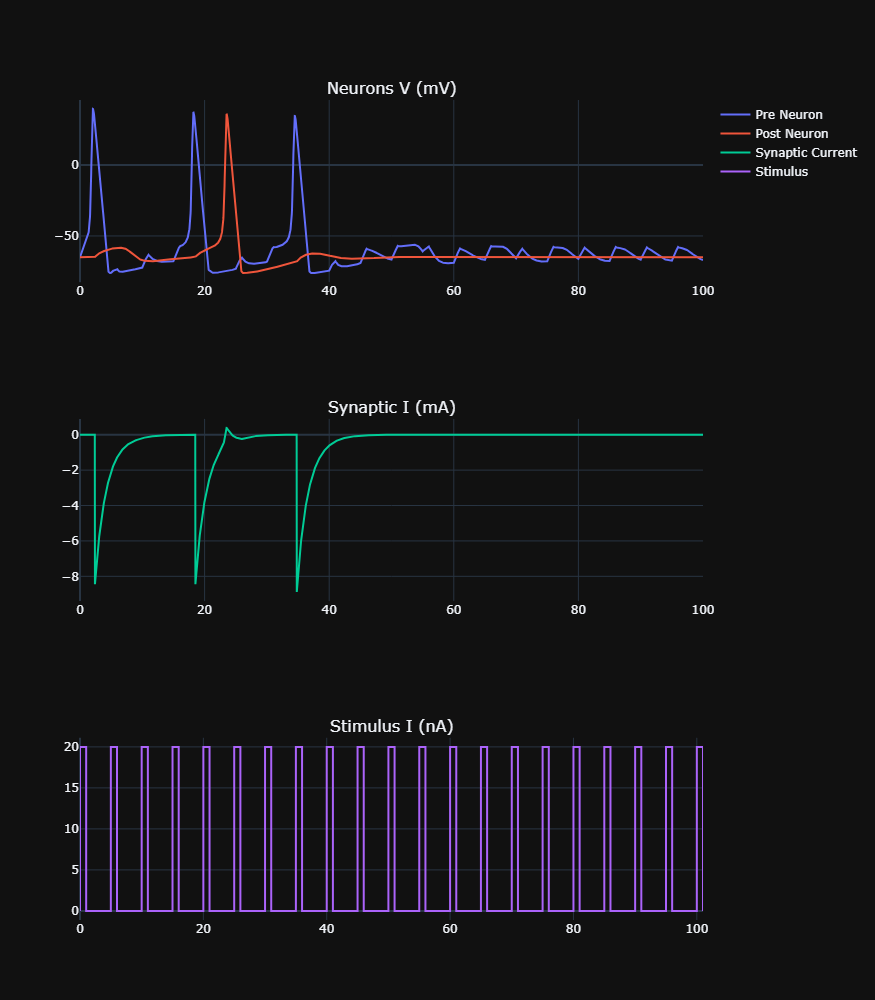

In [ ]:
# Create interactive plot
fig = make_subplots(rows=3, cols=1, subplot_titles=("Neurons V (mV)", "Synaptic I (mA)", "Stimulus I (nA)"))
fig.add_trace(go.Scatter(x=time, y=v1, mode='lines', name='Pre Neuron'), row=1, col=1)
fig.add_trace(go.Scatter(x=time, y=v2, mode='lines', name='Post Neuron'), row=1, col=1)
fig.add_trace(go.Scatter(x=time, y=syn_c, mode='lines', name='Synaptic Current'), row=2, col=1)
fig.add_trace(go.Scatter(x=t_vec, y=i_vec, mode='lines', name='Stimulus'), row=3, col=1)

fig.update_layout(height=1000, template='plotly_dark')

fig.show()

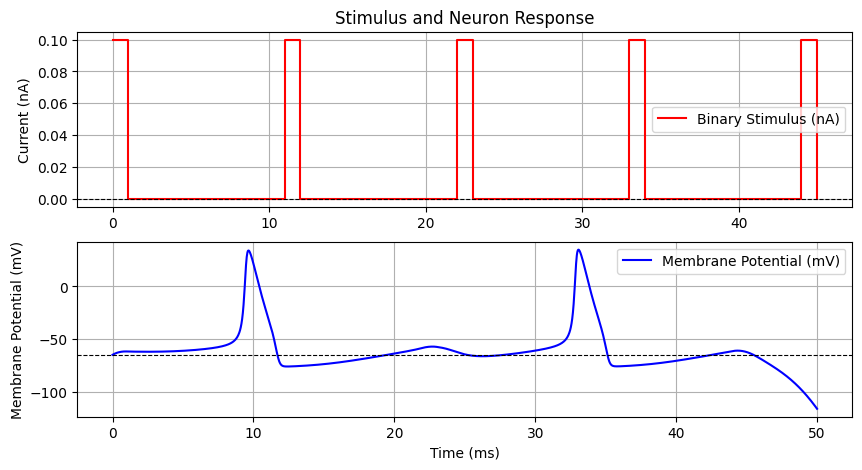

In [ ]:
from neuron import h, gui
import numpy as np
import matplotlib.pyplot as plt

# Создаём нейрон (сома с HH-каналами)
soma = h.Section(name='soma')
soma.L = soma.diam = 20  # Размеры сомы (мкм)
soma.insert('hh')  # Вставляем HH-каналы

# Источник тока (IClamp)
stim = h.IClamp(soma(0.5))  # В середине сегмента
stim.delay = 0  # Начинаем сразу
stim.dur = 1e9  # Делаем его "постоянным", управляя амплитудой через Vector.play()

# Формируем бинарный стимул: 100 нА на 1 мс каждые 11 мс
t_on = np.arange(0, 50, 11)  # Время включения (мс)
t_off = t_on + 1  # Время выключения (мс)

t_vec = np.sort(np.concatenate([t_on, t_off]))  # Чередуем включение/выключение
i_vec = np.tile([0.1, 0], len(t_on))  # 100 нА → 0 нА

# Передаём стимул в NEURON через Vector.play()
vec_t = h.Vector(t_vec)  # Временные точки
vec_i = h.Vector(i_vec)  # Значения тока
vec_i.play(stim._ref_amp, vec_t, 1)  # Играть ток по времени

# Запись мембранного потенциала
v_vec = h.Vector()
t_rec = h.Vector()
v_vec.record(soma(0.5)._ref_v)  # Записываем мембранный потенциал
t_rec.record(h._ref_t)  # Записываем время

# Запуск симуляции
h.finitialize(-65)  # Начальный потенциал (мВ)
h.continuerun(50)   # Запуск на 50 мс

# Построение графика стимуляции
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.step(t_vec, i_vec, where="post", label="Binary Stimulus (nA)", color="r")
plt.axhline(0, color='black', linewidth=0.8, linestyle="--")  # Линия 0
plt.ylabel("Current (nA)")
plt.title("Stimulus and Neuron Response")
plt.legend()
plt.grid(True)

# Построение графика мембранного потенциала
plt.subplot(2, 1, 2)
plt.plot(t_rec, v_vec, label="Membrane Potential (mV)", color="b")
plt.axhline(-65, color='black', linewidth=0.8, linestyle="--")  # Линия покоя
plt.xlabel("Time (ms)")
plt.ylabel("Membrane Potential (mV)")
plt.legend()
plt.grid(True)

plt.show()
